In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid
from scipy.stats import norm

In [235]:
# DATA GENERATION

N = 10000        # size of the dataset
P = 4            # number of weights
L = 10           # number of samples for MonteCarlo
M = 100          # size of batches


rand_seed = np.random.RandomState(0)

data_X = rand_seed.randn(N,P)
w_real = rand_seed.randn(P)
data_y = rand_seed.binomial(1,sigmoid(np.dot(data_X,w_real)))

## DEBUG

In [6]:
a = [tf.Variable(tf.zeros([10, 10]), name="p_W") for i in range(10)]

In [7]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [20]:
sess.run([A + tf.reshape(W[1,:,0], [1,-1]), tf.reshape(W[1,:,0], [1,-1])])

[array([[ 2.4634428 ,  1.19415343,  0.19139767],
        [ 2.4634428 ,  1.19415343,  0.19139767],
        [ 2.4634428 ,  1.19415343,  0.19139767]], dtype=float32),
 array([[ 1.46344292,  0.19415343, -0.80860233]], dtype=float32)]

In [207]:
std_samples = tf.random_normal(shape=[10, 4])
log_var_W = tf.constant([[1,2,3,4]], tf.float32)
mean_W = tf.constant([[5,6,7,8]], tf.float32)
w_from_q = tf.add(tf.multiply(std_samples, log_var_W), mean_W)
out = tf.add(tf.multiply(H, twos), tf.ones(10))
out2 = out + 1

samples = tf.random_normal(shape=[10, 2])

In [209]:
x = tf.constant([[1, 2, 3], [1, 2, 3], [1,2,3]])

z = tf.multiply(x, [1,2,3])

In [216]:
out = tf.reduce_sum(x,axis=1)
out_mean = tf.reduce_mean(out)

In [6]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
print(sess.run([A,B,C]))

[array([[[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]],

       [[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]],

       [[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]]], dtype=int32), array([[[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]], dtype=int32), array([[[6, 6, 6],
        [6, 6, 6],
        [6, 6, 6]],

       [[6, 6, 6],
        [6, 6, 6],
        [6, 6, 6]],

       [[6, 6, 6],
        [6, 6, 6],
        [6, 6, 6]]], dtype=int32)]


## DEBUG END

In [284]:
class VariationalLogReg(object):
    def __init__(self, n_datapoints, n_weights, n_samples, batch_size):
        # SIZES
        self.N = n_datapoints
        self.P = n_weights
        self.M = batch_size
        
        ## Batch data placeholders
        self.X = tf.placeholder(tf.float32, [None, n_weights])
        self.Y = tf.placeholder(tf.float32, [None])
        
        ## Set the number of Monte Carlo samples as a placeholder so that it can be different for training and test
        # self.L =  tf.placeholder(tf.int32)
        self.L = n_samples
        
        # PRIOR OF WEIGHTS
        self.prior_mean_W, self.log_prior_var_W = self.get_prior_W()
    
        # POSTERIOR OF WEIGHTS
        self.mean_W, self.log_var_W = self.init_posterior_W()
        
        ## Builds whole computational graph with relevant quantities as part of the class
        self.loss, self.kl, self.ell, self.layer_out = self.get_nelbo()

        ## Initialize the session
        self.session = tf.Session()
    

    def get_prior_W(self):
        """
        Define a prior for the weight distribution.
        We assume them to be standard normal iid.
        """
        prior_mean_W = tf.zeros(self.P, name="p_W")
        log_prior_var_W = tf.zeros(self.P, name="p_W")
        return prior_mean_W, log_prior_var_W

    def init_posterior_W(self):
        """
        The (variational) posterior is assumed to be
        drawn from P mutually independent normal distributions.
        Hence, we have a diagonal covariance matrix and only need to store an array.
        """
        mean_W = tf.Variable(tf.zeros(self.P), name="q_W")
        log_var_W = tf.Variable(tf.zeros(self.P), name="q_W")
        return mean_W, log_var_W
    
    def get_samples(self):
        """
        Draws L N(0,1) samples of dimension P.
        """
        return tf.random_normal(shape=[self.L, self.P])

    def sample_from_W(self):
        """
        Samples from the variational posterior approximation.
        We draw L w-samples of dimension P using the reparameterization trick.
        """
        z = self.get_samples()
        ## division by 2 to obtain pure standard deviation
        w_from_q = tf.add(tf.multiply(z, tf.exp(self.log_var_W / 2)), self.mean_W)
        return w_from_q
    
    def get_ell(self):
        """
        Returns the expected log-likelihood of the lower bound.
        For this we draw L samples from W, compute the log-likelihood for each
        and average the log-likelihoods in the end (expectation approximation).
        """
        
        w_sample = self.sample_from_W()
        # for each w, we compute the logistic regression output per training sample
        # this results in a n_training_samples X weight_samples matrix
        log_reg_out = tf.sigmoid(tf.matmul(self.X, tf.transpose(w_sample)))
        
        # we then use these predicted outputs to compute
        # the log-likelihood per weight sample (vector)
        log_p_per_sample = tf.reduce_sum(
            tf.add(
                tf.multiply(tf.transpose(tf.log(log_reg_out)), self.Y),
                tf.multiply(tf.transpose(tf.log(1-log_reg_out)), (1-self.Y))
            ), axis=1
        )
        
        # the vector of log-likelihoods needs to be averaged in the end
        # to give the expected log-likelihood approximation
        log_p = tf.reduce_mean(log_p_per_sample)
        return log_p, log_reg_out

    def get_kl(self):
        """
        KL[q || p] returns the KL-divergence between the prior p and the variational posterior q.
        :param mq: vector of means for q
        :param log_vq: vector of log-variances for q
        :param mp: vector of means for p
        :param log_vp: vector of log-variances for p
        :return: KL divergence between q and p
        """
        mq = self.mean_W
        log_vq = self.log_var_W
        mp = self.prior_mean_W
        log_vp = self.log_prior_var_W
        
        log_vp = tf.reshape(log_vp, (-1, 1))
        return 0.5 * tf.reduce_sum(log_vp - log_vq + (tf.pow(mq - mp, 2) / tf.exp(log_vp)) + tf.exp(log_vq - log_vp) - 1)

    def get_nelbo(self):
        """ Returns the negative ELBOW, which allows us to minimize instead of maximize. """
        kl = self.get_kl()
        ell, layer_out = self.get_ell()
        # DKL_gaussian - tf.mean([log_likelihood(w) for w in w_from_q])
        nelbo = kl - self.N/tf.cast(self.M, "float32") * ell
        return nelbo, kl, ell, layer_out
    
    def learn(self, learning_rate=0.01):
        """ Our learning procedure """
        optimizer = tf.train.AdamOptimizer(learning_rate)

        ## Set all_variables to contain the complete set of TF variables to optimize
        all_variables = tf.trainable_variables()

        ## Define the optimizer
        train_step = optimizer.minimize(self.loss, var_list=all_variables)

        ## Initialize all variables
        init = tf.global_variables_initializer()

        ## Initialize TF session
        self.session.run(init)

        ## Set the folder where the logs are going to be written 
        # summary_writer = tf.train.SummaryWriter('logs/', self.session.graph)
        #summary_writer = tf.summary.FileWriter('logs/', self.session.graph)

        for i in range(1000):
            indices = np.random.choice(N, M)
            X_batch, y_batch = data_X[indices], data_y[indices]
            self.session.run(train_step, feed_dict={self.X: X_batch, self.Y: y_batch})
            
            if i % 100 == 0:
                nelbo, kl, ell, _ = self.session.run(self.get_nelbo(),
                                feed_dict={self.X: data_X, self.Y: data_y})
                print("i=" + repr(i)  + "  kl=" + repr(kl) + "  nell=" + repr(-ell)  + "  nelbo=" + repr(nelbo), end="\n")
        
        mean_W_final = self.session.run(self.mean_W)
        log_var_W_final = self.session.run(self.log_var_W)
        
        return mean_W_final, log_var_W_final

In [285]:
vi = VariationalLogReg(N,P,L,M)
mu, log_var_W_final = vi.learn()

i=0  kl=0.0011987686  nell=12213.467  nelbo=1221346.6
i=100  kl=5.8168745  nell=6140.729  nelbo=614078.69
i=200  kl=12.564169  nell=4813.311  nelbo=481343.66
i=300  kl=17.759531  nell=4540.0718  nelbo=454024.94
i=400  kl=21.866377  nell=4200.6162  nelbo=420083.5
i=500  kl=24.545071  nell=4186.7368  nelbo=418698.22
i=600  kl=26.387152  nell=4117.9263  nelbo=411819.0
i=700  kl=28.122944  nell=4041.5649  nelbo=404184.62
i=800  kl=29.495417  nell=3981.5632  nelbo=398185.81
i=900  kl=30.529579  nell=3995.4148  nelbo=399572.0


In [282]:
sigma = np.exp(log_var_W_final)

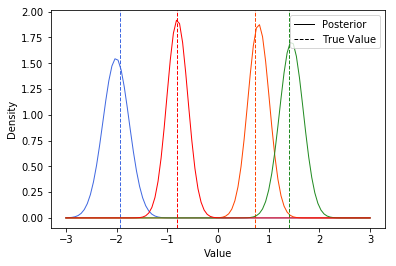

In [283]:
x_plot = np.linspace(-3, 3, 100)
plt.plot(x_plot,norm.pdf(x_plot, mu[0], np.sqrt(sigma[0])),"royalblue",linewidth=1,label="Posterior")
plt.axvline(x=w_real[0],c="royalblue",linestyle='dashed',linewidth=1,label="True Value")
plt.plot(x_plot,norm.pdf(x_plot, mu[1], np.sqrt(sigma[1])),c="orangered",linewidth=1)
plt.axvline(x=w_real[1],c="orangered",linestyle='dashed',linewidth=1)
plt.plot(x_plot,norm.pdf(x_plot, mu[2], np.sqrt(sigma[2])),c="forestgreen",linewidth=1)
plt.axvline(x=w_real[2],c="forestgreen",linestyle='dashed',linewidth=1)
plt.plot(x_plot,norm.pdf(x_plot, mu[3], np.sqrt(sigma[3])),c="red",linewidth=1)
plt.axvline(x=w_real[3],c="red",linestyle='dashed',linewidth=1)
plt.xlabel("Value")
plt.ylabel("Density")
leg = plt.legend(loc=1)
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_color('black')
plt.show()
#plt.savefig('densities.png', format='png',bbox_inches='tight',dpi = 300)

# Blackbox Variational Inference

In [272]:
# OPTIMIZE LIKELIHOOD - KL DIV between var. q(W) and prior p(W) -> 
# our error in negative
#  KLD is in closed version
#  Likelihood -> sample from variational dristribution with reparametrization


def elbo_grad(z_sample, mu, sigma):
    score_mu = (z_sample - mu)/(sigma)
    score_logsigma = (-1/(2*sigma) + np.power((z_sample - mu),2)/(2*np.power(sigma,2))) * sigma
    log_p = np.sum(data_y * np.log(sigmoid(np.dot(data_X,z_sample))) + (1-data_y) * np.log(1-sigmoid(np.dot(data_X,z_sample))))\
        + np.sum(norm.logpdf(z_sample, np.zeros(P), np.ones(P)))
    log_q = np.sum(norm.logpdf(z_sample, mu, np.sqrt(sigma)))
    return np.concatenate([score_mu,score_logsigma])*(log_p - log_q)

In [275]:
rs = np.random.RandomState(100)
S = 10
n_iter = 1000
mu = rs.randn(P)
G = np.zeros((2*P,2*P))
eta = 1.0
log_sigma = rs.randn(P)
mus = np.zeros((n_iter,P))
delta_lambda = np.zeros(n_iter)

In [276]:
print("Beginning to optimize")
for t in range(n_iter):
    mus[t] = mu
    if t % 500 == 0:
        print ("Iteration: ", t)
        print ("Mu: ", mu)
        print ("Sigma: ", np.exp(log_sigma))
    sigma = np.exp(log_sigma)
    samples = np.array([rs.normal(mu, np.sqrt(sigma)) for s in range(S)])
    grad_estimate = np.mean(np.array([elbo_grad(z_sample, mu, sigma) for z_sample in samples]),axis=0)
    G = G + np.outer(grad_estimate,grad_estimate)
    mu_new = mu + (eta * 1/np.sqrt(np.diag(G)))[:P] * grad_estimate[:P]
    log_sigma_new = log_sigma + (eta * 1/np.sqrt(np.diag(G)))[P:] * grad_estimate[P:]
    delta_lambda[t] = np.linalg.norm(mu_new-mu)
    if np.linalg.norm(mu_new-mu) < 0.01:
        break
    mu = mu_new
    log_sigma = log_sigma_new
print ("Optimization complete")
print ("Final mu: ", mu)
print ("Final sigma: ", np.exp(log_sigma))
print ("Real values: ", w_real)



Beginning to optimize
Iteration:  0
Mu:  [-1.74976547  0.3426804   1.1530358  -0.25243604]
Sigma:  [ 2.66797775  1.67233164  1.24754756  0.34299365]
Iteration:  500
Mu:  [-2.28648962  1.0114764   1.50760216 -0.44290998]
Sigma:  [ 0.06025406  0.1013667   0.07353196  0.04022029]
Optimization complete
Final mu:  [-2.0222631   0.59249106  1.41880819 -0.52257542]
Final sigma:  [ 0.12157415  0.04583503  0.06802027  0.01846606]
Real values:  [-1.93950036  0.73885045  1.39468453 -0.81358502]


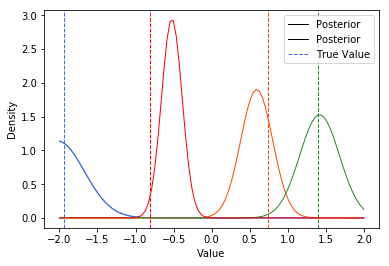

In [278]:
x_plot = np.linspace(-2, 2, 100)
plt.plot(x_plot,norm.pdf(x_plot, mu[0], np.sqrt(sigma[0])),"royalblue",linewidth=1,label="Posterior")
plt.axvline(x=w_real[0],c="royalblue",linestyle='dashed',linewidth=1,label="True Value")
plt.plot(x_plot,norm.pdf(x_plot, mu[1], np.sqrt(sigma[1])),c="orangered",linewidth=1)
plt.axvline(x=w_real[1],c="orangered",linestyle='dashed',linewidth=1)
plt.plot(x_plot,norm.pdf(x_plot, mu[2], np.sqrt(sigma[2])),c="forestgreen",linewidth=1)
plt.axvline(x=w_real[2],c="forestgreen",linestyle='dashed',linewidth=1)
plt.plot(x_plot,norm.pdf(x_plot, mu[3], np.sqrt(sigma[3])),c="red",linewidth=1)
plt.axvline(x=w_real[3],c="red",linestyle='dashed',linewidth=1)
plt.xlabel("Value")
plt.ylabel("Density")
leg = plt.legend(loc=1)
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_color('black')
plt.show()
plt.savefig('densities.png', format='png',bbox_inches='tight',dpi = 300)

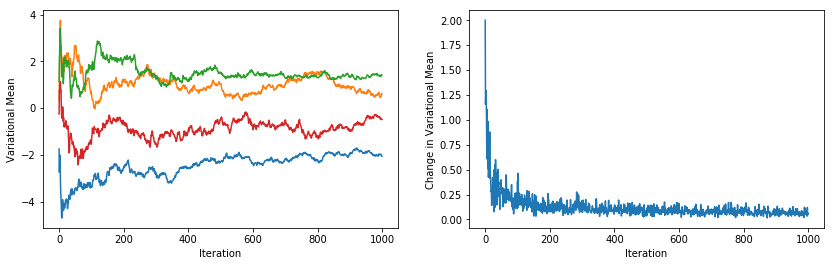

In [279]:
fig = plt.figure(figsize=(14,4), facecolor='white')
ax_1 = fig.add_subplot(121, frameon=True)
ax_2 = fig.add_subplot(122, frameon=True)
ax_1.plot(range(t+1),mus[:(t+1)])
ax_1.set_xlabel("Iteration")
ax_1.set_ylabel("Variational Mean")
ax_2.plot(range(t+1),delta_lambda[:(t+1)])
ax_2.set_xlabel("Iteration")
ax_2.set_ylabel("Change in Variational Mean")
plt.show()
plt.savefig('trace_plots.png', format='png',bbox_inches='tight',dpi=300)